In [4]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install networkx matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.6 MB/s eta 0:00:0000:01


In [7]:
# Imports and environment setup
import os, json, random
from copy import deepcopy
from collections import defaultdict
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# GNN layers
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, GATConv

# reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [8]:
# Helpers to infer dataset & extract IGL-Bench imbalance ratio from filename
import os

def infer_dataset_name_from_path(json_path: str) -> str:
    p = json_path.lower()
    if 'cora' in p:
        return 'Cora'
    if 'citeseer' in p or 'citeseer' in p:
        return 'CiteSeer'
    if 'pubmed' in p or 'pub' in p:
        return 'PubMed'
    raise ValueError(f"Cannot infer dataset name from path: {json_path}")

def extract_iglbench_ratio_from_filename(json_path: str) -> int:
    name = os.path.basename(json_path)
    stem = os.path.splitext(name)[0]
    try:
        return int(stem)
    except:
        raise ValueError(f"Filename {name} does not encode an integer imbalance ratio.")


In [9]:
# Model classes
class GCNNet(nn.Module):
    def __init__(self, in_dim, hid, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid)
        self.conv2 = GCNConv(hid, out_dim)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GraphSAGENet(nn.Module):
    def __init__(self, in_dim, hid, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid)
        self.conv2 = SAGEConv(hid, out_dim)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GATNet(nn.Module):
    def __init__(self, in_dim, hid, out_dim, heads=4, dropout=0.5):
        super().__init__()
        self.gat1 = GATConv(in_dim, hid, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hid*heads, out_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout
    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        return x

print("Models: GCN, GraphSAGE, GAT defined.")


Models: GCN, GraphSAGE, GAT defined.


In [10]:
# Load dataset and apply JSON split masks
def load_planetoid_with_json(json_path: str, root_dir: str = '/tmp'):
    ds_name = infer_dataset_name_from_path(json_path)
    with open(json_path, 'r') as f:
        split = json.load(f)
    ds = Planetoid(root=os.path.join(root_dir, ds_name), name=ds_name)
    data = ds[0]
    N = data.num_nodes

    train_mask = torch.zeros(N, dtype=torch.bool)
    val_mask   = torch.zeros(N, dtype=torch.bool)
    test_mask  = torch.zeros(N, dtype=torch.bool)

    train_idx = split.get('train', [])
    val_idx   = split.get('val', [])
    test_idx  = split.get('test', [])

    train_mask[train_idx] = True
    val_mask[val_idx]     = True
    test_mask[test_idx]   = True

    data = data.clone()
    data.train_mask = train_mask
    data.val_mask   = val_mask
    data.test_mask  = test_mask

    return data, ds


In [11]:
# GEFLogger: Logs node-level errors during GNN training and computes error propagation flows
class GEFLogger:
    def __init__(self, data: Data):
        """
        Initialize the logger for a graph dataset.
        
        Args:
            data (torch_geometric.data.Data): Graph data object containing edge_index and number of nodes
        """
        self.num_nodes = data.num_nodes  # total number of nodes in the graph
        
        # Convert edge_index to numpy arrays for easier processing
        ei = data.edge_index.cpu().numpy()
        src, dst = ei
        # Store edges as a list of tuples (source, target)
        self.edges = list(zip(src.tolist(), dst.tolist()))
        
        # Build adjacency list: node -> list of neighbors
        self.adj = defaultdict(list)
        for s, d in self.edges:
            self.adj[int(s)].append(int(d))
        
        # Stores per-epoch node error states (0 = correct, 1 = misclassified)
        self.error_states = []

    def log_epoch(self, preds: np.ndarray, labels: np.ndarray):
        """
        Log the errors of the current epoch.
        
        Args:
            preds (np.ndarray): Predicted labels for all nodes
            labels (np.ndarray): True labels for all nodes
        
        Returns:
            np.ndarray: 0/1 array indicating node misclassification for this epoch
        """
        errs = (preds != labels).astype(int)  # 1 if prediction is wrong, else 0
        self.error_states.append(errs)        # append this epoch's error state
        return errs

    def compute_edge_flows(self) -> Dict[Tuple[int,int], int]:
        """
        Compute the number of times errors propagate along each edge.
        Error propagation is counted when a node u is misclassified at epoch t
        and its neighbor v is misclassified at epoch t+1.
        
        Returns:
            dict: edge -> flow count
        """
        flows = defaultdict(int)
        T = len(self.error_states)
        if T < 2:  # need at least 2 epochs to compute propagation
            return dict(flows)
        
        # Iterate over consecutive epochs
        for t in range(T-1):
            prev = self.error_states[t]
            curr = self.error_states[t+1]
            for u, v in self.edges:
                if prev[u] == 1 and curr[v] == 1:  # error propagated from u->v
                    flows[(u, v)] += 1
        return dict(flows)

    def last_epoch_metrics(self) -> Dict[str,float]:
        """
        Compute summary metrics of error propagation between the last two epochs:
        - amplification_ratio: fraction of edges where error propagated
        - vanishing_ratio: fraction of edges where error vanished
        - persistence_rate: fraction of edges where error persisted over two nodes
        
        Returns:
            dict: metrics with keys 'amplification_ratio', 'vanishing_ratio', 'persistence_rate'
        """
        T = len(self.error_states)
        if T < 2:  # not enough epochs to compute metrics
            return {'amplification_ratio': 0.0, 'vanishing_ratio': 0.0, 'persistence_rate': 0.0}
        
        prev = self.error_states[-2]
        curr = self.error_states[-1]
        
        propagation = vanishing = persistence = total = 0
        
        # Iterate through all edges to compute metrics
        for u, v in self.edges:
            total += 1
            if prev[u] == 1 and curr[v] == 1:
                propagation += 1   # error propagated along edge
            elif prev[u] == 1 and curr[v] == 0:
                vanishing += 1     # error disappeared
            if prev[u] == 1 and prev[v] == 1 and curr[v] == 1:
                persistence += 1   # error persisted in both nodes
        
        total = max(1, total)  # avoid division by zero
        return {
            'amplification_ratio': propagation / total,
            'vanishing_ratio': vanishing / total,
            'persistence_rate': persistence / total
        }


In [12]:
# Build & visualize Error Flow Graph (EFG)
def build_efg_networkx(data: Data, flows: Dict[Tuple[int,int], int], min_weight:int = 1):
    """
    Construct a directed graph (EFG) from error flows.
    
    Parameters:
    - data: Data object containing graph info (num_nodes)
    - flows: dictionary mapping (u,v) edge to error propagation count
    - min_weight: minimum flow to include edge in the EFG
    
    Returns:
    - G: networkx.DiGraph representing the EFG
    """
    G = nx.DiGraph()
    # Add all nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges with weight >= min_weight
    for (u,v),w in flows.items():
        if w >= min_weight:
            G.add_edge(int(u), int(v), weight=int(w))
    return G

def visualize_efg(Gefg: nx.DiGraph, node_error_counts: np.ndarray=None, top_k_edges:int=200, figsize=(10,8)):
    """
    Visualize the Error Flow Graph using networkx.
    
    Parameters:
    - Gefg: networkx directed graph (EFG)
    - node_error_counts: optional array with cumulative misclassification per node
    - top_k_edges: number of highest-weight edges to display
    - figsize: figure size for plotting
    """
    if Gefg.number_of_edges() == 0:
        print("No edges to display in EFG.")
        return
    
    # Sort edges by weight (descending) and select top_k_edges
    edges_sorted = sorted(Gefg.edges(data='weight'), key=lambda x:x[2], reverse=True)
    sel = edges_sorted[:top_k_edges]
    
    # Create a subgraph with only the selected top edges
    H = Gefg.edge_subgraph([(u,v) for u,v,w in sel]).copy()
    
    # Compute layout for nodes
    pos = nx.spring_layout(H, seed=42)
    
    plt.figure(figsize=figsize)
    
    # Determine node colors based on cumulative error counts
    if node_error_counts is not None:
        vals = np.array([node_error_counts[n] if n < len(node_error_counts) else 0 for n in H.nodes()])
        maxv = vals.max() if vals.max()>0 else 1.0
        node_colors = vals / maxv  # normalize for colormap
    else:
        node_colors = 'lightgray'  # default color if no counts provided
    
    # Edge widths scaled by weight
    edge_weights = [H[u][v]['weight'] for u,v in H.edges()]
    widths = [max(0.5, w*0.2) for w in edge_weights]
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(H, pos, node_color=node_colors, cmap=plt.cm.Reds, node_size=80)
    
    # Draw edges
    nx.draw_networkx_edges(H, pos, width=widths, alpha=0.8, edge_color='gray', arrowsize=12)
    
    # Add colorbar for node misclassification
    plt.colorbar(nodes, label='Normalized cumulative misclassification')
    
    plt.title("Error Flow Graph (EFG) — top edges")
    plt.axis('off')
    plt.show()


In [13]:
# Compute per-class metrics and return structured dict
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    labels = list(np.unique(y_true))
    acc = accuracy_score(y_true, y_pred)
    p,r,f1,sup = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)
    per_class = []
    for lab, pp, rr, ff, s in zip(labels,p,r,f1,sup):
        per_class.append({'label': int(lab),'precision':float(pp),'recall':float(rr),'f1':float(ff),'support':int(s)})
    return {'accuracy':float(acc),'per_class':per_class}


In [14]:
# Baseline training with Cross-Entropy (CE) and per-epoch logging via GEFLogger
def train_baseline_with_logging(data: Data, model_cls, model_name:str, epochs=100, lr=0.01, weight_decay=5e-4, hidden=64, verbose=True):
    """
    Train a GNN model on the given data while logging per-epoch predictions
    for error flow analysis using GEFLogger.
    
    Parameters:
    - data: input Data object (PyG)
    - model_cls: GNN model class (to instantiate)
    - model_name: string name for logging purposes
    - epochs: number of training epochs
    - lr: learning rate for optimizer
    - weight_decay: L2 regularization term
    - hidden: number of hidden units in the model
    - verbose: whether to print training progress
    
    Returns:
    - results: dictionary containing trained model, GEFLogger, training history, predictions, and labels
    """
    
    # Make a CPU copy of data for logging purposes
    data_work = deepcopy(data).to('cpu')
    num_feat = data_work.num_node_features
    num_classes = int(data_work.y.max().item()) + 1  # compute number of classes

    # Initialize model and optimizer
    model = model_cls(num_feat, hidden, num_classes).to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize GEFLogger to track per-epoch misclassification
    gef = GEFLogger(data_work)
    
    # Prepare dictionary to store training metrics
    history = {'epoch':[],'train_loss':[],'train_acc':[],'val_acc':[],'test_acc':[]}

    # Training loop
    for epoch in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        
        # Forward pass
        logits = model(data_work.x.to(device), data_work.edge_index.to(device))
        logits_train = logits[data_work.train_mask.to(device)]
        y_train = data_work.y[data_work.train_mask].to(device)
        
        # Compute cross-entropy loss and backpropagate
        loss = F.cross_entropy(logits_train, y_train)
        loss.backward()
        opt.step()

        # Evaluation & logging
        model.eval()
        with torch.no_grad():
            logits_all = model(data_work.x.to(device), data_work.edge_index.to(device)).cpu()
            preds_all = logits_all.argmax(dim=1).cpu().numpy()  # predicted labels
            labels_all = data_work.y.cpu().numpy()              # true labels
            
            # Log per-epoch predictions in GEFLogger
            gef.log_epoch(preds_all, labels_all)

            # Prepare masks for train/val/test
            train_mask = data_work.train_mask.cpu().numpy().astype(bool)
            val_mask = data_work.val_mask.cpu().numpy().astype(bool) if hasattr(data_work,'val_mask') else np.zeros(data_work.num_nodes, dtype=bool)
            test_mask = data_work.test_mask.cpu().numpy().astype(bool) if hasattr(data_work,'test_mask') else np.zeros(data_work.num_nodes, dtype=bool)

            # Compute accuracy for each split
            train_acc = accuracy_score(labels_all[train_mask], preds_all[train_mask]) if train_mask.sum()>0 else 0.0
            val_acc = accuracy_score(labels_all[val_mask], preds_all[val_mask]) if val_mask.sum()>0 else 0.0
            test_acc = accuracy_score(labels_all[test_mask], preds_all[test_mask]) if test_mask.sum()>0 else 0.0

        # Store metrics in history
        history['epoch'].append(epoch)
        history['train_loss'].append(float(loss.cpu().item()))
        history['train_acc'].append(float(train_acc))
        history['val_acc'].append(float(val_acc))
        history['test_acc'].append(float(test_acc))

        # Print progress for first 5 epochs and periodically afterward
        if verbose and (epoch<=5 or epoch%max(1,epochs//10)==0):
            print(f"[{model_name}] Epoch {epoch:03d} | Loss {loss.item():.4f} | Train {train_acc:.4f} | Val {val_acc:.4f} | Test {test_acc:.4f}")

    # Final predictions and labels
    final_logits = model(data_work.x.to(device), data_work.edge_index.to(device)).cpu()
    final_preds = final_logits.argmax(dim=1).cpu().numpy()
    final_labels = data_work.y.cpu().numpy()
    
    # Package results
    results = {
        'model': model,        # trained model
        'gef': gef,            # GEFLogger instance
        'history': history,    # per-epoch metrics
        'preds': final_preds,  # final predictions
        'labels': final_labels # true labels
    }
    return results


In [15]:
# Compute node reweighting from GEF error logs 
def compute_efg_node_weights_from_gef(gef: GEFLogger, data: Data, alpha: float = 1.0, error_window:int = 1):
    """
    Compute per-node sample weights based on neighbor error fractions from the last `error_window` epochs.
    Returns numpy array of length N with sample weight = 1 + alpha * neighbor_score (in [1, 1+alpha]).
    """
    N = data.num_nodes
    # If no logs, return ones
    if len(gef.error_states) == 0:
        return np.ones(N, dtype=float)

    last_k = min(len(gef.error_states), error_window)
    recent = np.stack(gef.error_states[-last_k:], axis=0).sum(axis=0) / float(last_k)  # [N] values in [0,1]
    neighbor_score = np.zeros_like(recent, dtype=float)
    for n in range(N):
        neighs = gef.adj.get(n, [])
        if len(neighs) == 0:
            neighbor_score[n] = recent[n]
        else:
            neighbor_score[n] = float(np.mean([recent[nb] for nb in neighs]))
    node_weights = 1.0 + alpha * neighbor_score  # baseline 1.0
    return node_weights  # numpy array


In [16]:
# Retrain model using Cross-Entropy with per-sample weights derived from EFG node_weights
def retrain_with_node_weights(data: Data, model_cls, model_name:str, node_weights: np.ndarray, epochs=100, lr=0.01, weight_decay=5e-4, hidden=64, verbose=True):
    """
    Retrains a GNN model with weighted cross-entropy loss, where each training node
    is assigned a weight (from node_weights) to emphasize nodes that contributed
    more to error propagation in the previous GEF analysis.

    Parameters:
    - data: input Data object (PyG)
    - model_cls: GNN model class
    - model_name: string name for logging
    - node_weights: numpy array of length N, providing a weight per node (used only for training nodes)
    - epochs: number of training epochs
    - lr: learning rate
    - weight_decay: L2 regularization
    - hidden: hidden dimension of the model
    - verbose: whether to print progress

    Returns:
    - results: dictionary containing trained model, training history, final predictions, and labels
    """
    
    # Make a CPU copy of data for safe manipulation
    data_work = deepcopy(data).to('cpu')
    num_feat = data_work.num_node_features
    num_classes = int(data_work.y.max().item()) + 1

    # Initialize model and optimizer
    model = model_cls(num_feat, hidden, num_classes).to(device)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # History dictionary to store metrics
    history = {'epoch':[],'train_loss':[],'train_acc':[],'val_acc':[],'test_acc':[]}

    # Precompute global indices of training nodes to map node_weights correctly
    train_idx_global = data_work.train_mask.nonzero(as_tuple=False).view(-1).numpy()

    # Training loop
    for epoch in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        
        # Forward pass
        logits = model(data_work.x.to(device), data_work.edge_index.to(device))
        train_logits = logits[data_work.train_mask.to(device)]
        train_labels = data_work.y[data_work.train_mask].to(device)

        # Compute per-node cross-entropy loss (without reduction)
        per_node_loss = F.cross_entropy(train_logits, train_labels, reduction='none')  # shape [n_train]

        # Apply node_weights to per-node loss
        sample_weights = torch.tensor(node_weights[train_idx_global], dtype=torch.float32).to(device)
        per_node_loss = per_node_loss * sample_weights

        # Aggregate weighted loss
        loss = per_node_loss.mean()
        loss.backward()
        opt.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            logits_all = model(data_work.x.to(device), data_work.edge_index.to(device)).cpu()
            preds_all = logits_all.argmax(dim=1).cpu().numpy()
            labels_all = data_work.y.cpu().numpy()

            # Prepare masks for train/val/test splits
            train_mask = data_work.train_mask.cpu().numpy().astype(bool)
            val_mask = data_work.val_mask.cpu().numpy().astype(bool) if hasattr(data_work,'val_mask') else np.zeros(data_work.num_nodes, dtype=bool)
            test_mask = data_work.test_mask.cpu().numpy().astype(bool) if hasattr(data_work,'test_mask') else np.zeros(data_work.num_nodes, dtype=bool)

            # Compute accuracy per split
            train_acc = accuracy_score(labels_all[train_mask], preds_all[train_mask]) if train_mask.sum()>0 else 0.0
            val_acc = accuracy_score(labels_all[val_mask], preds_all[val_mask]) if val_mask.sum()>0 else 0.0
            test_acc = accuracy_score(labels_all[test_mask], preds_all[test_mask]) if test_mask.sum()>0 else 0.0

        # Save metrics for this epoch
        history['epoch'].append(epoch)
        history['train_loss'].append(float(loss.cpu().item()))
        history['train_acc'].append(float(train_acc))
        history['val_acc'].append(float(val_acc))
        history['test_acc'].append(float(test_acc))

        # Print progress for first 5 epochs and periodically after
        if verbose and (epoch<=5 or epoch%max(1,epochs//10)==0):
            print(f"[{model_name}] Epoch {epoch:03d} | Loss {loss.item():.4f} | Train {train_acc:.4f} | Val {val_acc:.4f} | Test {test_acc:.4f}")

    # Final predictions and labels
    final_logits = model(data_work.x.to(device), data_work.edge_index.to(device)).cpu()
    final_preds = final_logits.argmax(dim=1).cpu().numpy()
    final_labels = data_work.y.cpu().numpy()
    
    # Package results
    results = {'model':model,'history':history,'preds':final_preds,'labels':final_labels}
    return results


In [19]:
# Top-level experiment loop that runs baseline, computes EFG node weights and retrains, then saves metrics
# Edit this map to point to your JSON split files
dataset_json_map = {
    # Example: update these paths to your uploaded JSON files
    "CITESEER_R100": "/kaggle/input/citeseer/CiteSeer/100.json",
    
}

models_map = {
    'GCN': GCNNet,
    'GraphSAGE': GraphSAGENet,
    'GAT':GATNet

}

# Hyperparameters
epochs = 100        # increase for final experiments
lr = 0.01
hidden = 64
alpha = 2.0         # EFG reweight strength (node weight = 1 + alpha * neighbor_score)
error_window = 1    # how many recent epochs to average when computing neighbor_score

out_dir = "/kaggle/working/gef_results"
os.makedirs(out_dir, exist_ok=True)

all_runs = {}

for tag, json_path in dataset_json_map.items():
    if not os.path.exists(json_path):
        print(f"JSON not found: {json_path}. Skipping {tag}.")
        continue

    ds_name = infer_dataset_name_from_path(json_path)
    imb_ratio = extract_iglbench_ratio_from_filename(json_path)
    print("\n========================================")
    print(f"Dataset tag={tag} | dataset={ds_name} | imbalance={imb_ratio}:1 | split={json_path}")

    data, ds = load_planetoid_with_json(json_path)

    all_runs[tag] = {}

    for model_name, model_cls in models_map.items():
        run_name = f"{tag}__{model_name}__R{imb_ratio}"
        print("\n----- RUN:", run_name)

        # Baseline training (plain CE) with logging
        baseline = train_baseline_with_logging(data, model_cls, model_name=run_name+"_baseline", epochs=epochs, lr=lr, hidden=hidden, verbose=True)

        # Save baseline history & preds/labels
        b_hist_df = pd.DataFrame(baseline['history'])
        b_hist_df.to_csv(os.path.join(out_dir, f"{run_name}_baseline_history.csv"), index=False)
        np.save(os.path.join(out_dir, f"{run_name}_baseline_preds.npy"), baseline['preds'])
        np.save(os.path.join(out_dir, f"{run_name}_baseline_labels.npy"), baseline['labels'])

        # Compute per-class metrics for baseline
        baseline_metrics = compute_metrics(baseline['labels'], baseline['preds'])
        with open(os.path.join(out_dir, f"{run_name}_baseline_metrics.json"), "w") as f:
            json.dump(baseline_metrics, f, indent=2)

        print("Baseline accuracy:", baseline_metrics['accuracy'])
        print("Baseline per-class (first 6):", baseline_metrics['per_class'][:6])

        # Build EFG flows from baseline gef
        gef = baseline['gef']
        flows = gef.compute_edge_flows()
        metrics_efg = gef.last_epoch_metrics()  # amplification/vanishing/persistence
        # Save flows & efg metrics
        import pickle
        with open(os.path.join(out_dir, f"{run_name}_baseline_flows.pkl"), "wb") as f:
            pickle.dump(flows, f)
        with open(os.path.join(out_dir, f"{run_name}_baseline_efg_metrics.json"), "w") as f:
            json.dump(metrics_efg, f, indent=2)

        # Compute node-level weights from EFG (Option A)
        node_weights = compute_efg_node_weights_from_gef(gef, data, alpha=alpha, error_window=error_window)
        # Save node weights
        np.save(os.path.join(out_dir, f"{run_name}_node_weights.npy"), node_weights)

        # Retrain with node_weights
        retrain_res = retrain_with_node_weights(data, model_cls, model_name=run_name+"_retrain", node_weights=node_weights, epochs=epochs, lr=lr, hidden=hidden, verbose=True)

        # Save retrain history & preds/labels
        r_hist_df = pd.DataFrame(retrain_res['history'])
        r_hist_df.to_csv(os.path.join(out_dir, f"{run_name}_retrain_history.csv"), index=False)
        np.save(os.path.join(out_dir, f"{run_name}_retrain_preds.npy"), retrain_res['preds'])
        np.save(os.path.join(out_dir, f"{run_name}_retrain_labels.npy"), retrain_res['labels'])

        # Compute metrics for retrain
        retrain_metrics = compute_metrics(retrain_res['labels'], retrain_res['preds'])
        with open(os.path.join(out_dir, f"{run_name}_retrain_metrics.json"), "w") as f:
            json.dump(retrain_metrics, f, indent=2)

        print("Retrain accuracy:", retrain_metrics['accuracy'])
        print("Retrain per-class (first 6):", retrain_metrics['per_class'][:6])

        # Build EFG for retrain (optional): we could build a new GEF by re-running log during retrain; here we didn't log errors per epoch in retrain logger, but you can modify retrain function to return a GEFLogger if desired.
        # Save summary into all_runs
        all_runs[tag][model_name] = {
            'imbalance_ratio': imb_ratio,
            'baseline_metrics': baseline_metrics,
            'retrain_metrics': retrain_metrics,
            'baseline_history_path': os.path.join(out_dir, f"{run_name}_baseline_history.csv"),
            'retrain_history_path': os.path.join(out_dir, f"{run_name}_retrain_history.csv"),
            'flows_path': os.path.join(out_dir, f"{run_name}_baseline_flows.pkl"),
            'node_weights_path': os.path.join(out_dir, f"{run_name}_node_weights.npy")
        }

print("\nAll experiments finished. Results saved to:", out_dir)



Dataset tag=CITESEER_R100 | dataset=CiteSeer | imbalance=100:1 | split=/kaggle/input/citeseer/CiteSeer/100.json


Processing...
Done!



----- RUN: CITESEER_R100__GCN__R100
[CITESEER_R100__GCN__R100_baseline] Epoch 001 | Loss 1.8091 | Train 0.7327 | Val 0.2000 | Test 0.2264
[CITESEER_R100__GCN__R100_baseline] Epoch 002 | Loss 1.2334 | Train 0.7147 | Val 0.1879 | Test 0.2012
[CITESEER_R100__GCN__R100_baseline] Epoch 003 | Loss 0.8477 | Train 0.7447 | Val 0.2121 | Test 0.2331
[CITESEER_R100__GCN__R100_baseline] Epoch 004 | Loss 0.6459 | Train 0.8318 | Val 0.2515 | Test 0.2819
[CITESEER_R100__GCN__R100_baseline] Epoch 005 | Loss 0.5087 | Train 0.8859 | Val 0.3273 | Test 0.3544
[CITESEER_R100__GCN__R100_baseline] Epoch 010 | Loss 0.1788 | Train 0.9640 | Val 0.4182 | Test 0.4805
[CITESEER_R100__GCN__R100_baseline] Epoch 020 | Loss 0.0500 | Train 0.9880 | Val 0.4667 | Test 0.5372
[CITESEER_R100__GCN__R100_baseline] Epoch 030 | Loss 0.0314 | Train 0.9940 | Val 0.4667 | Test 0.5360
[CITESEER_R100__GCN__R100_baseline] Epoch 040 | Loss 0.0300 | Train 0.9970 | Val 0.4545 | Test 0.5225
[CITESEER_R100__GCN__R100_baseline] Epoch 050

In [20]:
# Saving metrics in excel
def save_metrics_to_excel(all_runs, output_path="all_metrics.xlsx"):
    """
    all_runs structure:
    all_runs[tag][model_name] = {
        'imbalance_ratio': ...,
        'baseline_metrics': {...},
        'retrain_metrics': {...},
        'baseline_history_path': ...,
        'retrain_history_path': ...,
        'flows_path': ...,
        'node_weights_path': ...
    }
    """

    writer = pd.ExcelWriter(output_path, engine='xlsxwriter')

    for tag, model_dict in all_runs.items():
        for model_name, info in model_dict.items():

            imb = info['imbalance_ratio']
            base = info['baseline_metrics']
            retr = info['retrain_metrics']

            # Extract per-class list for baseline
            base_rows = []
            for row in base['per_class']:
                base_rows.append({
                    "label": row['label'],
                    "baseline_precision": row['precision'],
                    "baseline_recall": row['recall'],
                    "baseline_f1": row['f1'],
                    "baseline_support": row['support'],
                })

            # Extract per-class list for retrain
            retr_rows = []
            for row in retr['per_class']:
                retr_rows.append({
                    "label": row['label'],
                    "retrain_precision": row['precision'],
                    "retrain_recall": row['recall'],
                    "retrain_f1": row['f1'],
                    "retrain_support": row['support'],
                })

            # Merge baseline + retrain on label
            df_base = pd.DataFrame(base_rows)
            df_retr = pd.DataFrame(retr_rows)
            df = pd.merge(df_base, df_retr, on="label", how="outer")

            # Add summary-level accuracy
            df.loc[len(df)] = {
                "label": "OVERALL",
                "baseline_precision": "",
                "baseline_recall": "",
                "baseline_f1": base['accuracy'],
                "baseline_support": "",
                "retrain_precision": "",
                "retrain_recall": "",
                "retrain_f1": retr['accuracy'],
                "retrain_support": "",
            }

            # Sheet name example:  Cora_GCN_IR20
            sheet_name = f"{tag}_{model_name}_IR{imb}"
            sheet_name = sheet_name[:31]  # Excel limit

            df.to_excel(writer, sheet_name=sheet_name, index=False)

    writer.close()
    print(f"Excel saved to: {output_path}")


In [21]:
save_metrics_to_excel(all_runs, output_path="all_metrics.xlsx")

Excel saved to: all_metrics.xlsx


Example run: CITESEER_R100 GCN imbalance: 100


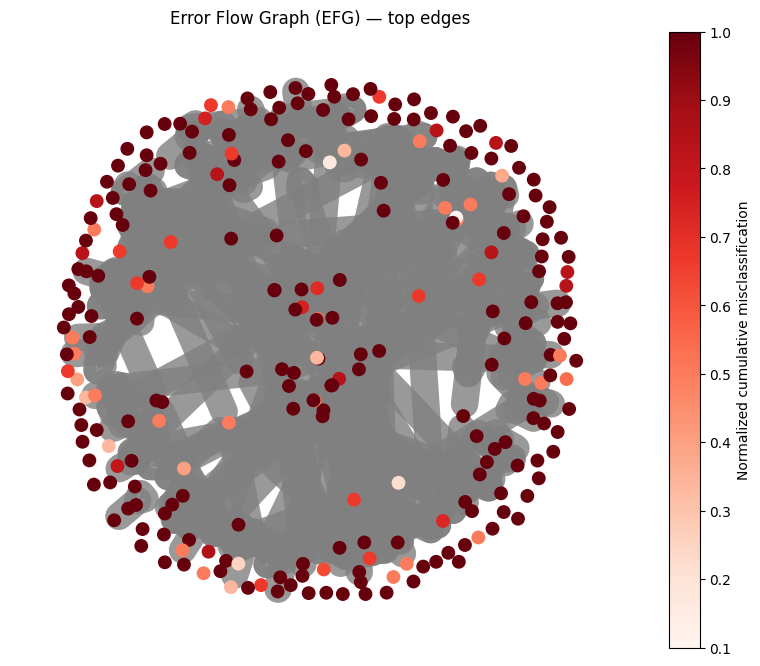

Baseline accuracy: 0.581605049594229
Retrain accuracy: 0.5761947700631199
Baseline per-class (first 7): [{'label': 0, 'precision': 0.375, 'recall': 0.011363636363636364, 'f1': 0.022058823529411763, 'support': 264}, {'label': 1, 'precision': 0.8208955223880597, 'recall': 0.3728813559322034, 'f1': 0.5128205128205129, 'support': 590}, {'label': 2, 'precision': 0.51252408477842, 'recall': 0.7964071856287425, 'f1': 0.6236811254396248, 'support': 668}, {'label': 3, 'precision': 0.5109204368174727, 'recall': 0.9343794579172611, 'f1': 0.6606152294503278, 'support': 701}, {'label': 4, 'precision': 0.7039187227866474, 'recall': 0.8137583892617449, 'f1': 0.754863813229572, 'support': 596}, {'label': 5, 'precision': 0.9523809523809523, 'recall': 0.07874015748031496, 'f1': 0.14545454545454542, 'support': 508}]
Retrain per-class (first 7): [{'label': 0, 'precision': 0.375, 'recall': 0.011363636363636364, 'f1': 0.022058823529411763, 'support': 264}, {'label': 1, 'precision': 0.79, 'recall': 0.4016949

In [22]:
# Example visualization for one run (pick tag and model)
# Update these keys to pick a saved run
if len(all_runs) > 0:
    example_tag = list(all_runs.keys())[0]
    example_model = list(all_runs[example_tag].keys())[0]
    run_info = all_runs[example_tag][example_model]
    print("Example run:", example_tag, example_model, "imbalance:", run_info['imbalance_ratio'])

    # Load baseline flows and node_weights
    import pickle
    with open(run_info['flows_path'], 'rb') as f:
        flows = pickle.load(f)
    node_weights = np.load(run_info['node_weights_path'])

    # Build EFG and visualize
    data_example, _ = load_planetoid_with_json(dataset_json_map[example_tag])
    efg_nx = build_efg_networkx(data_example, flows, min_weight=1)
    # Node cumulative errors (if baseline gef available)
    # We need baseline gef object to get error_states; load preds/labels and reconstruct per-epoch logs if required.
    # For now visualize with node_weights as intensity (higher weights -> more problematic)
    node_error_counts = node_weights - 1.0  # neighbor_score proxy
    visualize_efg(efg_nx, node_error_counts=node_error_counts, top_k_edges=200, figsize=(10,8))

    # Print per-class baseline and retrain metrics
    with open(run_info['baseline_metrics_path'] if 'baseline_metrics_path' in run_info else os.path.join(out_dir, f"{example_tag}__{example_model}__R{run_info['imbalance_ratio']}_baseline_metrics.json"), 'r') as f:
        baseline_metrics = json.load(f)
    with open(run_info['retrain_metrics_path'] if 'retrain_metrics_path' in run_info else os.path.join(out_dir, f"{example_tag}__{example_model}__R{run_info['imbalance_ratio']}_retrain_metrics.json"), 'r') as f:
        retrain_metrics = json.load(f)

    print("Baseline accuracy:", baseline_metrics['accuracy'])
    print("Retrain accuracy:", retrain_metrics['accuracy'])
    print("Baseline per-class (first 7):", baseline_metrics['per_class'][:7])
    print("Retrain per-class (first 7):", retrain_metrics['per_class'][:7])
else:
    print("No runs found in all_runs (run CELL 12 first).")
